<a href="https://colab.research.google.com/github/sazio/Transients/blob/master/Python/Trajectories%26Levy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install traja

In [6]:
import numpy as np
import pandas as pd 
import traja
import glob
import re
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
path_to_files = "drive/MyDrive/JamesSimoneSpatial/TrackFilesCue/CueCsv/Track/"

trackFiles = []
trackFiles = sorted(glob.glob(path_to_files + '*Track.csv'))

In [9]:
probeFiles = []

# Filtering probe trials 
# if probeFilter = True, probetrials are not used in the future statistics
# if probeFilter = False, probetrials are going to take part in the stats
probeFilter = True 

if probeFilter == True:
    regExpr = re.compile(r'p_Track')
    probeFiles = list(filter(lambda i : regExpr.search(i), trackFiles))
    trackFiles = list(filter(lambda i : not regExpr.search(i), trackFiles))
    
else : 
    trackFiles = trackFiles 

In [10]:
trackData = []
for i in tqdm(range(0,len(trackFiles))) : 
    trackData.append(pd.read_csv(trackFiles[i], names = ["time", "x", "y", "HeadAngle","EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"]))
    """_Track.csv files:
    Columns: T(s), X(m), Y(m), A(deg), R(Hz), D(m), V(m/s), S(m):
    T: camera frame time
    X: x coordinate of the head tip @ grid frame of reference
    Y: y coordinate of the head tip @ grid frame of reference
    A: head orientation
    R: EOD rate
    D: Distance per EOD pulse (=1/sampling_density)
    V: Head speed (m/s, signed)
    S: Distance per Escan (=1/escan_density)"""

In [11]:
# Creating list of probe Data as list of pandas dataframes 
probeData = []
for i in tqdm(range(0,len(probeFiles))) : 
    probeData.append(pd.read_csv(probeFiles[i], names = ["time", "x", "y", "HeadAngle","EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"]))

In [14]:
traja_steps = []
for i in tqdm(range(0, len(trackFiles[:19]))):

  trajaDF = traja.TrajaDataFrame(trackData[i])
  pivot = traja.step_lengths(trajaDF).dropna()
  pivot = pivot[pivot!= 0]

  traja_steps.append(pivot)

In [15]:
early_steps = traja_steps[0]

for i in tqdm(range(1,17)):
  early_steps = early_steps.append(traja_steps[i], ignore_index= True)

In [68]:
trackCurvData = []
for i in tqdm(range(0,len(trackFiles[:19]))):  
  trackCurvData.append(traja.rediscretize_points(trackData[i], R = 0.013)) # R = 0.013 is the step length , threshold of the previous distribution

In [69]:
early_curv = np.abs(traja.trajectory.calc_turn_angle(trackCurvData[0]).dropna())
for i in tqdm(range(1, len(trackCurvData))):
  early_curv.append(np.abs(traja.trajectory.calc_turn_angle(trackCurvData[i]).dropna()))

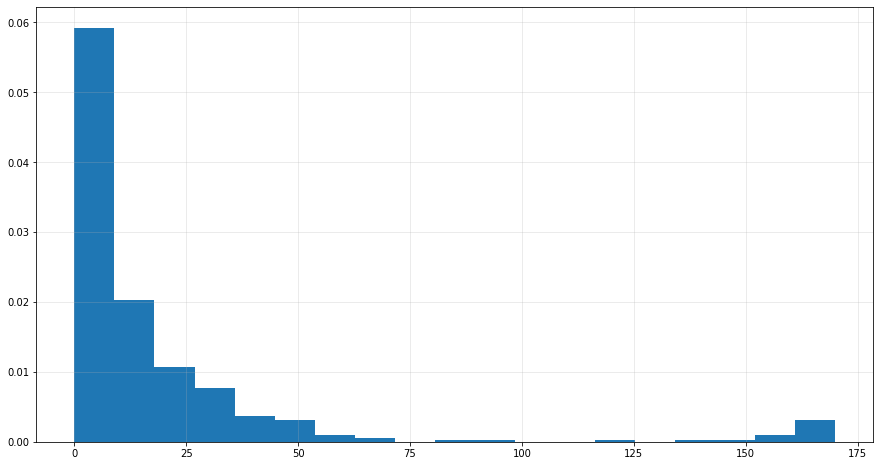

In [113]:
plt.figure(figsize = (15,8))
counts, bins, bars =  plt.hist(early_curv, bins = int(np.sqrt(early_curv.shape[0])), density = True)
#plt.ylim([0,50])
#plt.xlim([0,10])
plt.grid(alpha = 0.3)

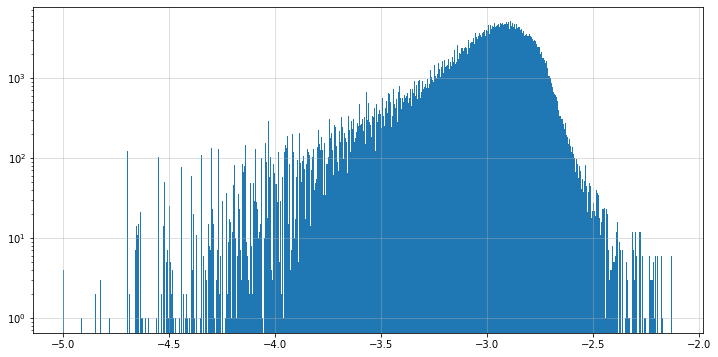

In [50]:
plt.figure(figsize = (12,6))
counts, bins, bars = plt.hist(np.log10(early_steps), bins = int(np.sqrt(early_steps.shape[0])), log = True)
plt.grid(alpha = 0.5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


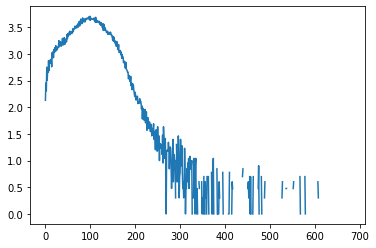

In [55]:
plt.plot(np.log10(counts))

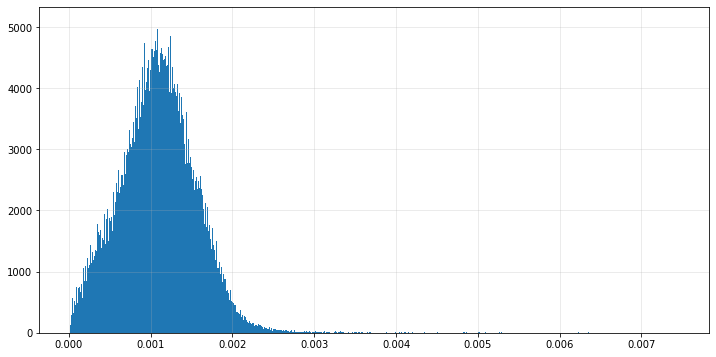

In [64]:
early_steps = early_steps#[early_steps > 0.0013] 
plt.figure(figsize = (12,6))
counts, bins, bars = plt.hist(early_steps, bins = int(np.sqrt(early_steps.shape[0])))
plt.grid(alpha = 0.3)
plt.savefig("distrib_early.png")

In [88]:
import scipy.stats as st
from scipy.optimize import curve_fit

In [ ]:
pconv = lambda mu, sigma: ( mu - sigma * beta * np.tan(np.pi * alpha / 2.0), sigma)
alpha, beta, mu, sigma = pconv(*st.levy._fitstart(bins))
print(alpha, beta, mu, sigma)

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


NameError: ignored

In [104]:
def levy_distrib(x, mu = 0 , c = 1): 
  return np.sqrt(c/(np.pi*2))*np.exp((-c/(2*(x-mu))))/((x-mu)*np.sqrt(x-mu))

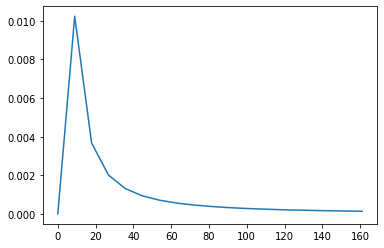

In [153]:
x = np.linspace(0,10, num = 100)
y = levy_distrib(x = bins[:-1], c = .5)
plt.plot(bins[:-1],y)

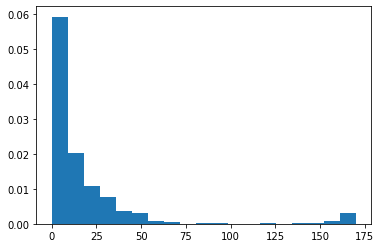

In [147]:
counts, bins, bars =  plt.hist(early_curv, bins = int(np.sqrt(early_curv.shape[0])) , density = True)

In [150]:
popt, pcov = curve_fit(levy_distrib, bins[:-1], counts)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


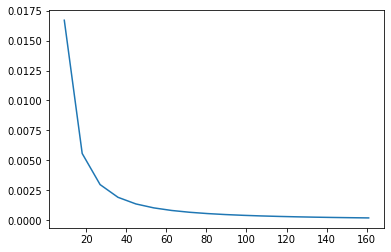

In [151]:
plt.plot(bins[:-1], levy_distrib(bins[:-1], *popt))

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


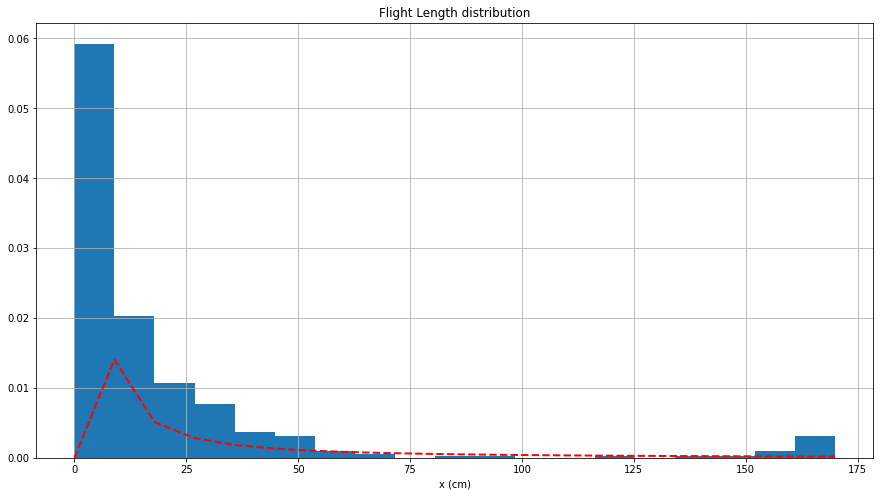

In [142]:
plt.figure(figsize = (15,8))
#n, bins, patches = plt.hist(x, int(np.sqrt(x.shape[0])), density = True, facecolor='green', alpha=0.55)
#counts, bins, bars =  plt.hist(early_curv, bins = int(np.sqrt(early_curv.shape[0])), density = True)
#counts, bins, bars = plt.hist(early_steps*2000, bins = int(np.sqrt(early_steps.shape[0])), density = True, facecolor='green', alpha=0.55)
counts, bins, bars =  plt.hist(early_curv, bins = int(np.sqrt(early_curv.shape[0])))#, density = True)

# add a 'best fit' line
#y = norm.pdf( bins, *norm._fitstart(bins))
y = st.levy.pdf(bins,*st.levy._fitstart(bins))

l = plt.plot(bins, y, 'r--', linewidth=2)


plt.title("Flight Length distribution")
plt.xlabel('x (cm)')
plt.ylabel('')

plt.grid(True)

plt.show()

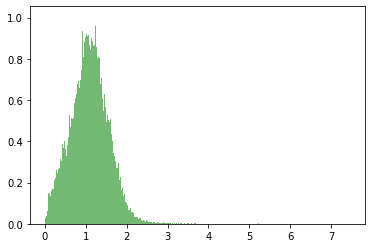

In [128]:
counts, bins, bars = plt.hist(early_steps*1000, bins = int(np.sqrt(early_steps.shape[0])), density = True, facecolor='green', alpha=0.55)